<center><span style="color:blue"><span style="font-size:30px">SMS Spam Collection</span></span></center>

<span style="color:black">The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,572 messages, tagged acording being ham (legitimate) or spam.This set of SMS messages is made of differents subsets.</span> <br>


<span style="color:black">A subset of 425 SMS spam messages was manually extracted from the Grumbletext Web site. This is a UK forum in which cell phone users make public claims about SMS spam messages, most of them without reporting the very spam message received.</span>

<span style="color:black">A subset of 3,375 SMS randomly chosen ham messages of the NUS SMS Corpus (NSC), which is a dataset of about 10,000 legitimate messages collected for research at the Department of Computer Science at the National University of Singapore. The messages largely originate from Singaporeans and mostly from students attending the University.</span>

<span style="color:black">A subset of 450 SMS ham messages collected from a PhD Thesis </span>

<span style="color:black">Finally,  a last subset was incorporated from the SMS Spam Corpus v.0.1 Big. It has 1,002 SMS ham messages and 322 spam messages</span> 

<span style="color:red">The goal of this notebook is to find machine best learning models to separate Ham and Spam messages</span>

In [1]:
#importing python packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix,make_scorer,classification_report,roc_auc_score,precision_score,recall_score,accuracy_score,f1_score
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from scipy import sparse
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, ImageColorGenerator
import warnings
warnings.filterwarnings("ignore")

In [3]:
#reading csv files
df = pd.read_csv('spam.csv',sep=',',encoding='iso-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


The last 3 columns of the dataset (Unnamed :2,Unnamed :3 and Unnamed :4) do not mean anything, so they will be suppressed. Moreover v1 and v2 will be renamed to label and message respectively.

In [5]:
df = df.drop('Unnamed: 2', 1)
df = df.drop('Unnamed: 3', 1)
df = df.drop('Unnamed: 4', 1)
df = df.rename(columns={'v1': 'label', 'v2': 'message'})
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


As 'message' processing algorithms will generate many columns, which will take up a lot of memory space and will require long time processing, we are going to analyze 2 features that may be important to separate ham messages and spam messages. These features might improve CPU time and memory space.<br>It is generally accepted that 'spam' messages have more punctuation and are longer than 'ham' messages. So 'length' and 'puncutuation' features will added to our dataset features

In [7]:
df['length']=df['message'].str.len()
df['punctuation']=df['message'].str.count('([.\?#@+,<>%~`!$^&\(\):;])')
df.head()

,label,message,length,punctuation
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,4
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,1


 Null values are checked

In [8]:
df.isnull().sum()

label          0
message        0
length         0
punctuation    0
dtype: int64

Messages are tested to look for texts where there are only spaces

In [9]:
df['message'].str.isspace().sum()

0

In [10]:
df['label'].unique()

array(['ham', 'spam'], dtype=object)

In [11]:
print("ham messages "+ str(df[df['label']=='ham']['label'].count()))
print("spam messages "+ str(df[df['label']=='spam']['label'].count()))

ham messages 4825
spam messages 747


In [12]:
ham=df[df['label']=='ham']['label'].count()
spam=df[df['label']=='spam']['label'].count()
hamper=ham/(ham+spam)*100
spamper=spam/(ham+spam)*100
print("There is {0:.2f}% of ham messages and {1:.2f}% of spam messages".format(hamper,spamper))

There is 86.59% of ham messages and 13.41% of spam messages


We are going to test 'length' and 'punctuation' separately from 'messages'.

<span style='color:red'><span style='font-size:22px'>Features  'length' and 'punctuation'</span></span>

In [13]:
# 'length' feature parameters
df['length'].describe()

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: length, dtype: float64

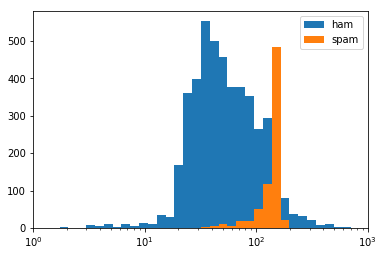

In [14]:
plt.figure
plt.xscale('log')
bins=1.2**(np.arange(0,80))
plt.hist(df[df['label']=='ham']['length'],bins=bins)
plt.hist(df[df['label']=='spam']['length'],bins=bins)
plt.legend(['ham','spam'])
plt.title('Length Feature')
plt.xlim(1,1000)
plt.show()

We can see on the histogram that spam and ham messages can be separated by 'length' feature. 

In [15]:
# 'punctuation' feature parameters
df['punctuation'].describe()

count    5572.000000
mean        3.489950
std         4.026444
min         0.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       132.000000
Name: punctuation, dtype: float64

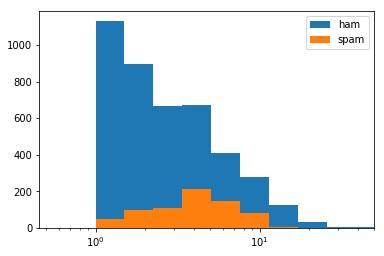

In [16]:
plt.figure
plt.xscale('log')
bins=1.5**(np.arange(0,40))
plt.hist(df[df['label']=='ham']['punctuation'],bins=bins)
plt.hist(df[df['label']=='spam']['punctuation'],bins=bins)
plt.legend(['ham','spam'])
plt.title('Punctuation feature')
plt.xlim(0,50)
plt.show()

From the previous histogram we can see that it is difficult to separate ham and spam messages taking into account 'punctuation' feature

We could discard __punctuation__ as significant feature because discrimination with this feature is very poor.<br> However as we have only 2 features, we are going to keep both and test them for several models.
Thus we are going to generate train and test sets for __length__ and __punctuation__ features.

In [94]:
X=df[['length','punctuation']]

In [95]:
y=df['label'].values

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.30, random_state=5)

We are going to check the distribution of classes in training set and test set to validate further results. 

In [20]:
unique, counts = np.unique(y_train, return_counts=True)
mydict_train=dict(zip(unique, counts))
unique, counts = np.unique(y_test, return_counts=True)
mydict_test=dict(zip(unique, counts))

In [21]:
print('ham percentage in training set {0:.2f}%'.format(mydict_train['ham']/(mydict_train['ham']+mydict_train['spam'])*100))
print('spam percentage in training set {0:.2f}%'.format(mydict_train['spam']/(mydict_train['ham']+mydict_train['spam'])*100))

ham percentage in training set 86.59%
spam percentage in training set 13.41%


In [22]:
print('ham percentage in testing set {0:.2f}%'.format(mydict_test['ham']/(mydict_test['ham']+mydict_test['spam'])*100))
print('spam percentage in testing set {0:.2f}%'.format(mydict_test['spam']/(mydict_test['ham']+mydict_test['spam'])*100))

ham percentage in training set 86.60%
spam percentage in training set 13.40%


The use of stratify parameter gives similar distributions in training and test sets.

For model testing, to be able to use metrics like precision and recall, y_train and y_test values (__spam__ and __ham__) need to be changed in binary numbers.

In [97]:
y_train=np.where(y_train=='spam',1,0)
y_test=np.where(y_test=='spam',1,0)

<span style='color:blue' ><span style='font-size:20px'>Models test</span></span>

As our dataset has unbalanced classes, global accuracy is not the most important metric. In that case we are going to improve a custom function to optimize at the same time miscclassified spam messages and misclassified ham messages. 

In [30]:
def my_custom_loss_func(y_test,y_pred):
    alpha=min(precision_score(y_test,y_pred),recall_score(y_test,y_pred))
    return alpha*(precision_score(y_test,y_pred)+recall_score(y_test,y_pred))

<span style='color:red' ><span style='font-size:15px'>Logistic Regression</span></span>

In [31]:
#tuning LogisticRegression
C1=np.logspace(-6, 1, 20)
C2=[1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8]
param_grid = [{'C':C2,'solver':['liblinear']},{'solver':['lbfgs'],'C':C1}]
acc_scorer = make_scorer(my_custom_loss_func)
clf = LogisticRegression(penalty='l2',random_state=42,class_weight='balanced',solver='lbfgs')
grid_search=GridSearchCV(clf, param_grid, scoring=acc_scorer,
cv=5, return_train_score=True,verbose=0)
grid_result = grid_search.fit(X_train,y_train)

In [32]:
#testing LogisticRegression model
lr_model=LogisticRegression(C=grid_result.best_params_['C'],solver=grid_result.best_params_['solver'],random_state=42, penalty='l2',class_weight='balanced')
lr_model.fit(X_train,y_train)#training the model
y_pred=lr_model.predict(X_test)#predicting outputs

In [33]:
#confusion matrix
cm=confusion_matrix(y_test,y_pred)

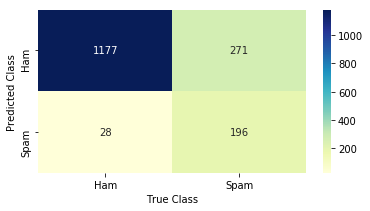

In [34]:
labels=['Ham','Spam']
plt.figure(figsize=(6,3))
sns.heatmap(cm,annot=True,cmap="YlGnBu",xticklabels=labels,yticklabels=labels,fmt='g')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.show()

In [39]:
#global metrics report
print("Global accuracy is {0:.2f}%".format(accuracy_score(y_test,y_pred)*100))
print("Minimum value for recall or precision is {0:.2f}% for spam messages".format(min(precision_score(y_test,y_pred),recall_score(y_test,y_pred))*100))
print()
print(classification_report(y_test,y_pred))

Global accuracy is 82.12%
Minimum value for recall or precision is 41.97% for spam messages

              precision    recall  f1-score   support

           0       0.98      0.81      0.89      1448
           1       0.42      0.88      0.57       224

   micro avg       0.82      0.82      0.82      1672
   macro avg       0.70      0.84      0.73      1672
weighted avg       0.90      0.82      0.84      1672



<span style='color:red' ><span style='font-size:15px'>Linear Support Vector Machine</span></span>

In [47]:
#tuning Linear Support Vector Machine
C=[0.2,0.3,0.4,0.5,0.6,1,10,20]
param_grid = [{'C':C}]
acc_scorer = make_scorer(my_custom_loss_func)
clf = LinearSVC(class_weight='balanced',random_state=42)
grid_search=GridSearchCV(clf, param_grid, scoring=acc_scorer,
cv=5, return_train_score=True,verbose=0,n_jobs=-1)
grid_result = grid_search.fit(X_train,y_train)
C=grid_result.best_params_['C']

In [48]:
#testing the model
linsvm_model=LinearSVC(C=grid_result.best_params_['C'],class_weight='balanced',random_state=42)
linsvm_model.fit(X_train,y_train) #training the model
y_pred=linsvm_model.predict(X_test) #predicting the outputs

In [49]:
#confusion matrix
cm=confusion_matrix(y_test,y_pred)

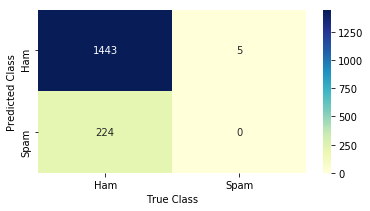

In [50]:
labels=['Ham','Spam']
plt.figure(figsize=(6,3))
sns.heatmap(cm,annot=True,cmap="YlGnBu",xticklabels=labels,yticklabels=labels,fmt='g')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.show()

In [51]:
#global metrics report
print("Global accuracy is {0:.2f}%".format(accuracy_score(y_test,y_pred)*100))
print("Minimum value for recall or precision is {0:.2f}% for spam messages".format(min(precision_score(y_test,y_pred),recall_score(y_test,y_pred))*100))
print()
print(classification_report(y_test,y_pred))

Global accuracy is 86.30%
Minimum value for recall or precision is 0.00% for spam messages

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1448
           1       0.00      0.00      0.00       224

   micro avg       0.86      0.86      0.86      1672
   macro avg       0.43      0.50      0.46      1672
weighted avg       0.75      0.86      0.80      1672



<span style='color:red' ><span style='font-size:15px'>Non Linear Support Vector Machine</span></span>

In [53]:
#tuning Support Vector Machine
C=[1,2,3,4,5,6]
gamma=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
param_grid = [{'C':C,'gamma':gamma}]
acc_scorer = make_scorer(my_custom_loss_func)
clf = SVC(kernel='rbf')
grid_search=GridSearchCV(clf, param_grid, scoring=acc_scorer,
cv=5, return_train_score=True,verbose=0,n_jobs=-1)
grid_result = grid_search.fit(X_train,y_train)

In [54]:
#testing the model
svm_model=SVC(C=grid_result.best_params_['C'],kernel='rbf',gamma=grid_result.best_params_['gamma'])
svm_model.fit(X_train,y_train) #training the model
y_pred=svm_model.predict(X_test) #predicting the outputs

In [55]:
#Confusion matrix
cm=confusion_matrix(y_test,y_pred)

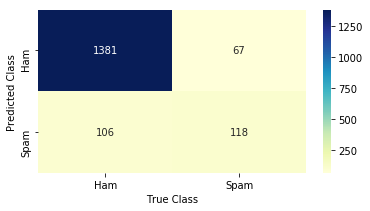

In [56]:
labels=['Ham','Spam']
plt.figure(figsize=(6,3))
sns.heatmap(cm,annot=True,cmap="YlGnBu",xticklabels=labels,yticklabels=labels,fmt='g')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.show()

In [58]:
#global metrics report
print("Global accuracy is {0:.2f}%".format(accuracy_score(y_test,y_pred)*100))
print("Minimum value for recall or precision is {0:.2f}% for spam messages".format(min(precision_score(y_test,y_pred),recall_score(y_test,y_pred))*100))
print()
print(classification_report(y_test,y_pred))

Global accuracy is 89.65%
Minimum value for recall or precision is 52.68% for spam messages

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1448
           1       0.64      0.53      0.58       224

   micro avg       0.90      0.90      0.90      1672
   macro avg       0.78      0.74      0.76      1672
weighted avg       0.89      0.90      0.89      1672



<span style='color:red' ><span style='font-size:15px'>Random Forrest</span></span>

In [66]:
#tuning Random Forest
n_estimators=[50,100,200,300]
min_samples_leaf=[2,3,4,5,6]
param_grid = [{'n_estimators':n_estimators,'min_samples_leaf':min_samples_leaf}]
acc_scorer = make_scorer(my_custom_loss_func)
clf = RandomForestClassifier(random_state=20,class_weight='balanced')
grid_search=GridSearchCV(clf, param_grid, scoring=acc_scorer,
cv=5, return_train_score=True,verbose=0,n_jobs=-1)
grid_result = grid_search.fit(X_train,y_train)

In [67]:
#testing the model
rf_model=RandomForestClassifier(n_estimators=grid_result.best_params_['n_estimators'],random_state=20,min_samples_leaf=grid_result.best_params_['min_samples_leaf'])
rf_model.fit(X_train,y_train) #training the model
y_pred=rf_model.predict(X_test) #predicting the outputs

In [68]:
#Confusion matrix
cm=confusion_matrix(y_test,y_pred)

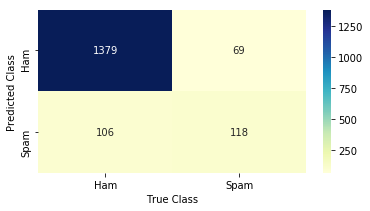

In [69]:
labels=['Ham','Spam']
plt.figure(figsize=(6,3))
sns.heatmap(cm,annot=True,cmap="YlGnBu",xticklabels=labels,yticklabels=labels,fmt='g')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.show()

In [70]:
#global metrics report
print("Global accuracy is {0:.2f}%".format(accuracy_score(y_test,y_pred)*100))
print("Minimum value for recall or precision is {0:.2f}% for spam messages".format(min(precision_score(y_test,y_pred),recall_score(y_test,y_pred))*100))
print()
print(classification_report(y_test,y_pred))

Global accuracy is 89.53%
Minimum value for recall or precision is 52.68% for spam messages

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1448
           1       0.63      0.53      0.57       224

   micro avg       0.90      0.90      0.90      1672
   macro avg       0.78      0.74      0.76      1672
weighted avg       0.89      0.90      0.89      1672



<span style='color:red' ><span style='font-size:15px'>XGBoost Classifier</span></span>

In [77]:
#tuning XGBoost Classifier
learning_rate=[0.1,0.12,0.14]
n_estimators=[300,400,500]
max_depth=[2,3,4]
subsample=[0.9,1]
colsample_bytree=[0.2,0.3,0.4]
param_grid = [{'n_estimators':n_estimators,'learning_rate':learning_rate,'max_depth':max_depth,'subsample':subsample,'colsample_bytree':colsample_bytree}]
acc_scorer = make_scorer(my_custom_loss_func)
clf = XGBClassifier(min_child_weight=1,gamma=0.5,nthread=4,objective= 'binary:logistic',scale_pos_weight=1,seed=27)
grid_search=GridSearchCV(clf, param_grid, scoring=acc_scorer,
cv=5, return_train_score=True,verbose=0,n_jobs=-1)
grid_result = grid_search.fit(X_train,y_train)

In [78]:
#test the model
xgb_model = XGBClassifier(
 learning_rate =grid_result.best_params_['learning_rate'],
 n_estimators=grid_result.best_params_['n_estimators'],
 max_depth=grid_result.best_params_['max_depth'],
 min_child_weight=1,
 gamma=0.5,
 subsample=grid_result.best_params_['subsample'],
 colsample_bytree=grid_result.best_params_['colsample_bytree'],
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb_model.fit(X_train,y_train) #training the model
y_pred=xgb_model.predict(X_test) #predicting the outputs

In [79]:
#Confusion matrix
cm=confusion_matrix(y_test,y_pred)

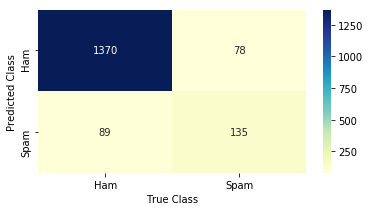

In [80]:
labels=['Ham','Spam']
plt.figure(figsize=(6,3))
sns.heatmap(cm,annot=True,cmap="YlGnBu",xticklabels=labels,yticklabels=labels,fmt='g')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.show()

In [81]:
#global metrics report
print("Global accuracy is {0:.2f}%".format(accuracy_score(y_test,y_pred)*100))
print("Minimum value for recall or precision is {0:.2f}% for spam messages".format(min(precision_score(y_test,y_pred),recall_score(y_test,y_pred))*100))
print()
print(classification_report(y_test,y_pred))

Global accuracy is 90.01%
Minimum value for recall or precision is 60.27% for spam messages

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1448
           1       0.63      0.60      0.62       224

   micro avg       0.90      0.90      0.90      1672
   macro avg       0.79      0.77      0.78      1672
weighted avg       0.90      0.90      0.90      1672



As a summary, we may say that __length__ and __punctuation__ features may help in terms of memory usage and time calculation. However the resuls are not satisfactory as there are many spam messages misclassified as well as ham messages. In some models a small improvement could be achieved, but we will not expect a global accuraracy over 91% and a minimum value for precision or recall over 62%<br>
So we are going to analyze text messages to try to improve those results.

<span style='color:red'><span style='font-size:22px'>Feature 'message'</span></span>

In [103]:
X=df['message']

In [104]:
y=df['label'].values

We will separate our original dataset in training set and test set.

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.30, random_state=14)

As 'message' feature is a categorical data we shall transform text into numeric data. From python librairies we could use CountVectorizer to separe text in words and count the number of times a word appears in a text. But We could also use another function TfidfVectorizer() which means term frequency inverse document frequency. This function give words more weigth to more important words(used along all the messages).<br><br> Any of these 2 functions can be used here, but for testing models we will only preprocess data with TfidfVectorizer. 

<span style='color:blue'>TfidfVectorizer encoder<span>

In [108]:
tfidf_vectorizer=TfidfVectorizer()
X_train_tfidf=tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf=tfidf_vectorizer.transform(X_test)

X_train_count and X_test_count are sparse matrices (matrices which most of the elements are zero). The methods fit_transform and transform generate a special sparse matrix which is compressed to try to reduce memory space.

In [109]:
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(3900, 7106)
(1672, 7106)


In these matrices every row corresponds to a message(3900 for training and 1672 for test) and every column corresponds to a unique word present in all the messages(7106 for training and test sets)

In [111]:
y_train=np.where(y_train=='spam',1,0)
y_test=np.where(y_test=='spam',1,0)

<span style='color:blue' ><span style='font-size:20px'>Models test</span></span>

<span style='color:red' ><span style='font-size:15px'>Linear Support Vector Machine</span></span>

In [119]:
#tuning Linear Support Vector Machine
C=[0.4,0.49,0.5,0.51,0.6]
param_grid = [{'C':C}]
acc_scorer = make_scorer(my_custom_loss_func)
clf = LinearSVC(class_weight='balanced',random_state=42,penalty='l2')
grid_search=GridSearchCV(clf, param_grid, scoring=acc_scorer,
cv=5, return_train_score=True,verbose=0,n_jobs=-1)
grid_result = grid_search.fit(X_train_tfidf,y_train)

In [120]:
#testing the model for best C
linsvc_model=LinearSVC(C=grid_result.best_params_['C'],class_weight='balanced',random_state=42,penalty='l2')
linsvc_model.fit(X_train_tfidf,y_train) #training the model
y_pred=linsvc_model.predict(X_test_tfidf) #predicting the outputs

In [121]:
#Confusion matrix
cm=confusion_matrix(y_test,y_pred)

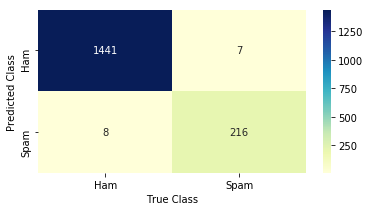

In [122]:
labels=['Ham','Spam']
plt.figure(figsize=(6,3))
sns.heatmap(cm,annot=True,cmap="YlGnBu",xticklabels=labels,yticklabels=labels,fmt='g')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.show()

In [124]:
#global metrics report
print("Global accuracy is {0:.2f}%".format(accuracy_score(y_test,y_pred)*100))
print("Minimum value for recall or precision is {0:.2f}% for spam messages".format(min(precision_score(y_test,y_pred),recall_score(y_test,y_pred))*100))
print()
print(classification_report(y_test,y_pred))

Global accuracy is 99.10%
Minimum value for recall or precision is 96.43% for spam messages

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1448
           1       0.97      0.96      0.97       224

   micro avg       0.99      0.99      0.99      1672
   macro avg       0.98      0.98      0.98      1672
weighted avg       0.99      0.99      0.99      1672



<span style='color:red' ><span style='font-size:15px'>Logistic Regression</span></span>

In [125]:
#tuning LogisticRegression
C1=np.logspace(-6, 1, 20)
C2=[1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8]
param_grid = [{'C':C2,'solver':['liblinear']},{'solver':['lbfgs'],'C':C1}]
acc_scorer = make_scorer(my_custom_loss_func)
clf = LogisticRegression(penalty='l2',random_state=42,class_weight='balanced')
grid_search=GridSearchCV(clf, param_grid, scoring=acc_scorer,
cv=5, return_train_score=True,verbose=0,n_jobs=-1)
grid_result = grid_search.fit(X_train_tfidf,y_train)

In [126]:
#defining the model
lr_model=LogisticRegression(C=grid_result.best_params_['C'],solver=grid_result.best_params_['solver'],random_state=42, penalty='l2',class_weight='balanced')
lr_model.fit(X_train_tfidf,y_train)#training the model
y_pred=lr_model.predict(X_test_tfidf)#predicting outputs

In [127]:
#Confusion matrix
cm=confusion_matrix(y_test,y_pred)

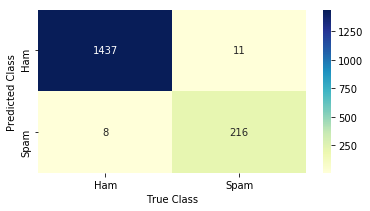

In [128]:
labels=['Ham','Spam']
plt.figure(figsize=(6,3))
sns.heatmap(cm,annot=True,cmap="YlGnBu",xticklabels=labels,yticklabels=labels,fmt='g')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.show()

In [129]:
#global metrics report
print("Global accuracy is {0:.2f}%".format(accuracy_score(y_test,y_pred)*100))
print("Minimum value for recall or precision is {0:.2f}% for spam messages".format(min(precision_score(y_test,y_pred),recall_score(y_test,y_pred))*100))
print()
print(classification_report(y_test,y_pred))

Global accuracy is 98.86%
Minimum value for recall or precision is 95.15% for spam messages

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1448
           1       0.95      0.96      0.96       224

   micro avg       0.99      0.99      0.99      1672
   macro avg       0.97      0.98      0.98      1672
weighted avg       0.99      0.99      0.99      1672



<span style='color:red' ><span style='font-size:15px'>Non Linear Support Vector Machine</span></span>

In [135]:
#tuning Support Vector Machine
C=[2,3]
gamma=[0.6,0.7,0.8]
param_grid = [{'C':C,'gamma':gamma}]
acc_scorer = make_scorer(my_custom_loss_func)
clf = SVC(kernel='rbf')
grid_search=GridSearchCV(clf, param_grid, scoring=acc_scorer,
cv=5, return_train_score=True,verbose=0,n_jobs=-1)
grid_result = grid_search.fit(X_train_tfidf,y_train)

In [136]:
#defining the model
svm_model=SVC(C=grid_result.best_params_['C'],kernel='rbf',gamma=grid_result.best_params_['gamma'])
svm_model.fit(X_train_tfidf,y_train) #training the model
y_pred=svm_model.predict(X_test_tfidf) #predicting the outputs

In [137]:
#Confusion matrix
cm=confusion_matrix(y_test,y_pred)

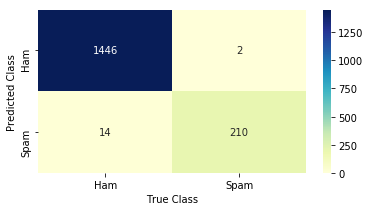

In [138]:
labels=['Ham','Spam']
plt.figure(figsize=(6,3))
sns.heatmap(cm,annot=True,cmap="YlGnBu",xticklabels=labels,yticklabels=labels,fmt='g')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.show()

In [139]:
#global metrics report
print("Global accuracy is {0:.2f}%".format(accuracy_score(y_test,y_pred)*100))
print("Minimum value for recall or precision is {0:.2f}% for spam messages".format(min(precision_score(y_test,y_pred),recall_score(y_test,y_pred))*100))
print()
print(classification_report(y_test,y_pred))

Global accuracy is 99.04%
Minimum value for recall or precision is 93.75% for spam messages

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1448
           1       0.99      0.94      0.96       224

   micro avg       0.99      0.99      0.99      1672
   macro avg       0.99      0.97      0.98      1672
weighted avg       0.99      0.99      0.99      1672



<span style='color:red' ><span style='font-size:15px'>Random Forrest</span></span>

In [156]:
#tuning Random Forest
n_estimators=[600,700,800]
min_samples_leaf=[2,3,4,5,6]
param_grid = [{'n_estimators':n_estimators,'min_samples_leaf':min_samples_leaf}]
acc_scorer = make_scorer(my_custom_loss_func)
clf = RandomForestClassifier(random_state=20,class_weight='balanced')
grid_search=GridSearchCV(clf, param_grid, scoring=acc_scorer,
cv=5, return_train_score=True,verbose=5,n_jobs=-1)
grid_result = grid_search.fit(X_train_tfidf,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  8.0min finished


{'min_samples_leaf': 2, 'n_estimators': 700}

In [157]:
#testing the model
rf_model=RandomForestClassifier(class_weight='balanced',n_estimators=grid_result.best_params_['n_estimators'],random_state=20,min_samples_leaf=grid_result.best_params_['min_samples_leaf'])
rf_model.fit(X_train_tfidf,y_train) #training the model
y_pred=rf_model.predict(X_test_tfidf) #predicting the outputs

In [158]:
#Confusion matrix
cm=confusion_matrix(y_test,y_pred)

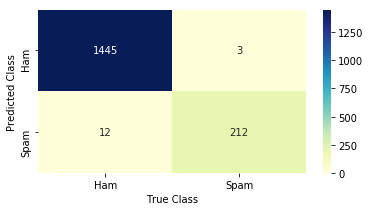

In [159]:
labels=['Ham','Spam']
plt.figure(figsize=(6,3))
sns.heatmap(cm,annot=True,cmap="YlGnBu",xticklabels=labels,yticklabels=labels,fmt='g')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.show()

In [160]:
#global metrics report
print("Global accuracy is {0:.2f}%".format(accuracy_score(y_test,y_pred)*100))
print("Minimum value for recall or precision is {0:.2f}% for spam messages".format(min(precision_score(y_test,y_pred),recall_score(y_test,y_pred))*100))
print()
print(classification_report(y_test,y_pred))

Global accuracy is 99.10%
Minimum value for recall or precision is 94.64% for spam messages

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1448
           1       0.99      0.95      0.97       224

   micro avg       0.99      0.99      0.99      1672
   macro avg       0.99      0.97      0.98      1672
weighted avg       0.99      0.99      0.99      1672



<span style='color:red' ><span style='font-size:15px'>XGBClassifier</span></span>

In [161]:
#tuning XGBosst Classifier
learning_rate=[0.06,0.07,0.08,0.09]
n_estimators=[600,605,610,620]
max_depth=[7]
subsample=[1.0]
colsample_bytree=[0.1]
seed=[27]
param_grid = [{'seed':seed,'n_estimators':n_estimators,'learning_rate':learning_rate,'max_depth':max_depth,'subsample':subsample,'colsample_bytree':colsample_bytree}]
acc_scorer = make_scorer(my_custom_loss_func,greater_is_better=True)
clf = XGBClassifier(min_child_weight=1,gamma=0,nthread=4,objective= 'binary:logistic',scale_pos_weight=20)
grid_search=GridSearchCV(clf, param_grid, scoring=acc_scorer,
cv=5, return_train_score=True,verbose=0,n_jobs=-1)
grid_result = grid_search.fit(X_train_tfidf,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  3.0min finished


{'colsample_bytree': 0.1,
 'learning_rate': 0.07,
 'max_depth': 7,
 'n_estimators': 620,
 'seed': 27,
 'subsample': 1.0}

In [162]:
#defining the model
xgb_model = XGBClassifier(
 learning_rate =grid_result.best_params_['learning_rate'],
 n_estimators=grid_result.best_params_['n_estimators'],
 max_depth=grid_result.best_params_['max_depth'],
 min_child_weight=1,
 gamma=0,
 subsample=grid_result.best_params_['subsample'],
 colsample_bytree=grid_result.best_params_['colsample_bytree'],
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=20,
 seed=grid_result.best_params_['seed'])
xgb_model.fit(X_train_tfidf,y_train) #training the model
y_pred=xgb_model.predict(X_test_tfidf) #predicting the outputs

In [163]:
#Confusion matrix
cm=confusion_matrix(y_test,y_pred)

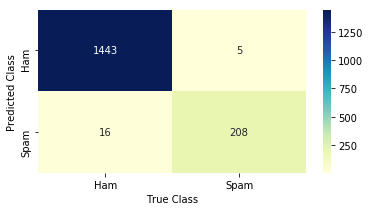

In [164]:
labels=['Ham','Spam']
plt.figure(figsize=(6,3))
sns.heatmap(cm,annot=True,cmap="YlGnBu",xticklabels=labels,yticklabels=labels,fmt='g')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.show()

In [165]:
#global metrics report
print("Global accuracy is {0:.2f}%".format(accuracy_score(y_test,y_pred)*100))
print("Minimum value for recall or precision is {0:.2f}% for spam messages".format(min(precision_score(y_test,y_pred),recall_score(y_test,y_pred))*100))
print()
print(classification_report(y_test,y_pred))

Global accuracy is 98.74%
Minimum value for recall or precision is 92.86% for spam messages

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1448
           1       0.98      0.93      0.95       224

   micro avg       0.99      0.99      0.99      1672
   macro avg       0.98      0.96      0.97      1672
weighted avg       0.99      0.99      0.99      1672



__It is obvious that using word features give better results. Perhaps with a long fine tuning we could improve some of the model results. At that time, LinearSVC gives the best results of Global Accuracy (99,10%) and minimum precision or recall (96,43%).__

We could try to combine message feature with length feature to check if there is any improvement. punctuation feature is discarded as the histogram shows that is very difficult to discriminate spam messages and ham messages.

<span style='color:red'><span style='font-size:22px'>Combination of 'message' and 'length' features</span></span>

Creating training and test sets for these 2 features separately

In [166]:
X_lenpun=df['length'].values
X_text=df['message'].values
y=df['label'].values

In [168]:
X_train_lenpun, X_test_lenpun, y_train_lenpun, y_test_lenpun = train_test_split(X_lenpun, y, stratify=y,test_size=0.30, random_state=14)
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(X_text, y, stratify=y,test_size=0.30, random_state=14)

In [169]:
#create sparse matrix of words
tfidf_vectorizer=TfidfVectorizer()
X_train_text_tfidf=tfidf_vectorizer.fit_transform(X_train_text)
X_test_text_tfidf=tfidf_vectorizer.transform(X_test_text)

We are going to normalize these matrices as words and lengths do not have similar weights

In [170]:
X_train_text_tfidf=normalize(X_train_text_tfidf,axis=0)
X_test_text_tfidf=normalize(X_test_text_tfidf,axis=0)

In [171]:
X_train_lenpun=X_train_lenpun.reshape(-1,1)
X_test_lenpun=X_test_lenpun.reshape(-1,1)
X_train_lenpun=normalize(X_train_lenpun,axis=0)
X_test_lenpun=normalize(X_test_lenpun,axis=0)

We are going to transform words sparse matrices into matrices to combine with length matrices and retransform the global combination into sparse matrices to save memory

In [172]:
X_train_result=np.hstack((X_train_lenpun,X_train_text_tfidf.toarray()))
X_test_result=np.hstack((X_test_lenpun,X_test_text_tfidf.toarray()))
X_train_final=sparse.csr_matrix(X_train_result)
X_test_final=sparse.csr_matrix(X_test_result)

We will test this combination with the model LinearSVC which gives the best results for __message__ feature.

In [175]:
y_train_text=np.where(y_train_text=='spam',1,0)
y_test_text=np.where(y_test_text=='spam',1,0)

In [205]:
#tuning Linear Support Vector Machine
C=[0.38,0.39,0.395,.4,0.405,0.41]
random_state=[2,4,8,10,12,16,20,24,28,32,34,40,42,46]
param_grid = [{'C':C,'random_state':random_state}]
acc_scorer = make_scorer(my_custom_loss_func)
clf = LinearSVC(class_weight='balanced',penalty='l2')
grid_search=GridSearchCV(clf, param_grid, scoring=acc_scorer,
cv=5, return_train_score=True,verbose=5,n_jobs=-1)
grid_result = grid_search.fit(X_train_final,y_train_text)
grid_result.best_params_

Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:   15.3s finished


{'C': 0.39, 'random_state': 2}

In [206]:
#testing the model for best result
linsvc_model=LinearSVC(C=grid_result.best_params_['C'],class_weight='balanced',random_state=grid_result.best_params_['random_state'],penalty='l2')
linsvc_model.fit(X_train_final,y_train_text) #training the model
y_pred=linsvc_model.predict(X_test_final) #predicting the outputs

In [207]:
#Confusion matrix
cm=confusion_matrix(y_test_text,y_pred)

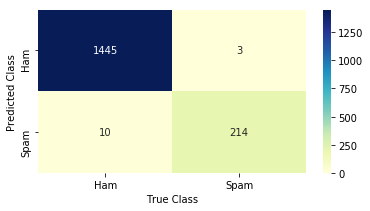

In [208]:
labels=['Ham','Spam']
plt.figure(figsize=(6,3))
sns.heatmap(cm,annot=True,cmap="YlGnBu",xticklabels=labels,yticklabels=labels,fmt='g')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.show()

In [204]:
#global metrics report
print("Global accuracy is {0:.2f}%".format(accuracy_score(y_test_text,y_pred)*100))
print("Minimum value for recall or precision is {0:.2f}% for spam messages".format(min(precision_score(y_test_text,y_pred),recall_score(y_test_text,y_pred))*100))
print()
print(classification_report(y_test_text,y_pred))

Global accuracy is 99.22%
Minimum value for recall or precision is 95.54% for spam messages

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1448
           1       0.99      0.96      0.97       224

   micro avg       0.99      0.99      0.99      1672
   macro avg       0.99      0.98      0.98      1672
weighted avg       0.99      0.99      0.99      1672



__Finally with the combination of length and message features we have a global improvement of accuracy(99,22%. Only 13 messages among 1672 have been missclassified. 3 spam messages have been predicted as ham messages and 10 ham messages have been predicted as spam messages.__

Let us check which words usually appear in spam messages and which words usually appear in ham messages.

<span style='color:blue' ><span style='font-size:20px'>Messages WordCloud</span></span>

In [210]:
#we create 2 dataframes with spam labels and ham labels
spam_df=df[df['label']=='spam'][['message']]
ham_df=df[df['label']=='ham'][['message']]

In [211]:
#function which eliminates punctuation, multiple spaces, numbers and stop words
def text_processing(string):
    
    if type(string) == str:

        string = re.sub(r'[^\w\s]',' ',string)
        string= re.sub(r'\b[0-9]+\b\s*', ' ', string)
        string = re.sub(r"\s+", ' ', string)
    
        stop_words = stopwords.words('english')
        mylist=[]
        for word in string:
            mylist.append(word.lower())
        string=''.join(mylist) 
    
        word_tokens = word_tokenize(string) 
    
        filtered_sentence = [] 
        stop_words = stopwords.words('english')
        for w in word_tokens: 
            if w not in stop_words: 
                filtered_sentence.append(w) 

        string=' '.join(filtered_sentence)
    
    return string

In [212]:
#test processing of spam and ham dataframes
spam_df['message']=spam_df['message'].apply(lambda x: text_processing(x))
ham_df['message']=ham_df['message'].apply(lambda x: text_processing(x))

<span style='color:red'>SPAM message WordCloud</span>

In [213]:
#creating text will words in all spam messages
spam_text=''
for i in range(spam_df['message'].count()):
    spam_text=spam_text+' '+str(spam_df['message'].iloc[i])

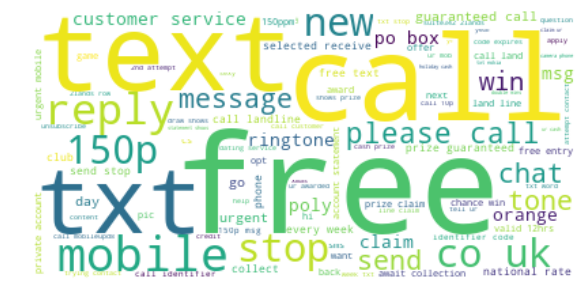

In [214]:
#SPAM wordcloud
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(spam_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<span style='color:red'>HAM message WordCloud</span>

In [215]:
ham_text=''
for i in range(ham_df['message'].count()):
    ham_text=ham_text+' '+str(ham_df['message'].iloc[i])

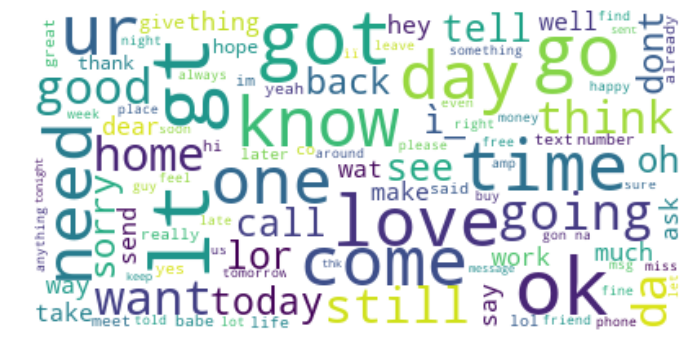

In [216]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(ham_text)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()